In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install permetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

import time
from glob import glob
from tqdm import tqdm
from permetrics.regression import RegressionMetric

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras import backend as K
#from keras.utils import plot_model
from tensorflow.keras.layers import InputLayer

from keras.layers import Activation, Dense, LSTM, GRU, Bidirectional, AveragePooling1D, GlobalAveragePooling1D, Dropout, Flatten, BatchNormalization, TimeDistributed, Input, Reshape, RepeatVector, Concatenate, GlobalMaxPooling1D 
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
from sklearn.metrics import r2_score

#GPU 자원이 부족
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## 데이터 불러오기, 공통 전처리

In [ ]:
newdata5 = pd.read_csv('/content/drive/MyDrive/신입기수 프로젝트/Dataset/newdata5.csv', encoding = 'cp949')
df = newdata5[['방류량', '강화대교_조위']]
df['한강대교_유량'] = pd.read_csv('/content/drive/MyDrive/신입기수 프로젝트/Dataset/newdata7_한강대교_유량_광진교_제외.csv', encoding = 'cp949')
df['청담대교_유량'] = pd.read_csv('/content/drive/MyDrive/신입기수 프로젝트/Dataset/newdata7_청담대교_유량_GRU.csv', encoding = 'cp949')

# 광진수위, 행주유량, 수위4개 데이터셋 가져오고, 마지막 6912개 수위 데이터 replace
수위유량 = pd.read_csv('/content/drive/MyDrive/신입기수 프로젝트/Dataset/Copy of 0827 광진행주유량수위x4.csv', encoding = 'cp949')

In [ ]:
수위유량.iloc[-6912:, [2, 3, 4, 5]] = newdata5.iloc[-6912:, [-4, -3, -2, -1]]

raw_data = pd.concat([df, 수위유량], axis = 1)
raw_data

,방류량,강화대교_조위,한강대교_유량,청담대교_유량,광진교_수위,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
0,575.70,193.0,729.80,469.05,1.20,540.18,310.7,300.2,290.0,275.3
1,575.30,199.0,731.48,498.00,1.20,540.18,314.7,300.2,290.0,275.3
2,555.00,207.0,726.42,490.68,1.20,540.18,313.7,301.2,290.0,275.3
3,575.70,215.0,726.42,476.21,1.20,552.17,311.7,301.2,290.0,276.3
4,575.40,226.0,707.17,476.21,1.20,564.29,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...,...
276331,258.67,407.0,-456.41,319.84,1.12,974.40,288.0,295.0,299.0,306.0
276332,258.58,431.0,-717.30,314.01,1.12,1006.88,287.0,303.0,304.0,308.0
276333,258.56,453.0,-843.37,387.55,1.12,1039.90,299.0,307.0,309.0,310.0
276334,258.65,476.0,-1023.37,454.91,1.12,1073.46,309.0,311.0,314.0,312.0


In [ ]:
# x y 나누기
input_y = raw_data[['청담대교_수위','잠수교_수위','한강대교_수위','행주대교_수위']]
input_x = raw_data

# 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

input_x_regular = input_x.copy()

for i in range(len(input_x.columns)):
    scaler = MinMaxScaler()                       #StandardScaler() , MinMaxScaler() , RobustScaler()
    a=np.array(input_x_regular.iloc[:,i])
    tmp_x = scaler.fit_transform(a.reshape(-1,1))
    input_x_regular.iloc[:,i] = tmp_x

input_regular = pd.concat([input_x_regular, input_y], axis = 1)
input_regular

,방류량,강화대교_조위,한강대교_유량,청담대교_유량,광진교_수위,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
0,0.058462,0.191781,0.147596,0.010523,0.056452,0.011070,0.049611,0.060000,0.051621,0.056478,310.7,300.2,290.0,275.3
1,0.058447,0.199253,0.147654,0.011862,0.056452,0.011070,0.053502,0.060000,0.051621,0.056478,314.7,300.2,290.0,275.3
2,0.057689,0.209215,0.147478,0.011523,0.056452,0.011070,0.052529,0.061111,0.051621,0.056478,313.7,301.2,290.0,275.3
3,0.058462,0.219178,0.147478,0.010854,0.056452,0.011475,0.050584,0.061111,0.051621,0.058140,311.7,301.2,290.0,276.3
4,0.058451,0.232877,0.146810,0.010854,0.056452,0.011883,0.050584,0.061111,0.052821,0.059801,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276331,0.046624,0.458281,0.106425,0.003624,0.045699,0.025719,0.027529,0.054222,0.062425,0.107475,288.0,295.0,299.0,306.0
276332,0.046621,0.488169,0.097370,0.003355,0.045699,0.026815,0.026556,0.063111,0.068427,0.110797,287.0,303.0,304.0,308.0
276333,0.046620,0.515567,0.092994,0.006755,0.045699,0.027929,0.038230,0.067556,0.074430,0.114120,299.0,307.0,309.0,310.0
276334,0.046624,0.544209,0.086747,0.009870,0.045699,0.029061,0.047957,0.072000,0.080432,0.117442,309.0,311.0,314.0,312.0


## train / test data 생성

In [ ]:
xdata = []
ydata = []
xdata_idx = []
ydata_idx = [-4,-3,-2,-1]
for i in range(len(input_regular.columns)-4):
    xdata_idx.append(i)

w =  6 #window size

idx = []
for i in range(12):
  idx.append(i*26496)

for i in tqdm(range(11)):
    if i != 10:
        tmp = input_regular[idx[i]:idx[i+1]]
    else:
        tmp = input_regular[idx[i]:]

    for j in range(len(tmp)-w):
        xdata.append(np.array(tmp.iloc[j:j + w, xdata_idx]).astype(float))

    for j in range(w,len(tmp)):
        ydata.append(np.array(tmp.iloc[j, ydata_idx]).astype(float))

100%|██████████| 11/11 [03:29<00:00, 19.08s/it]


In [ ]:
xdata_ = np.array(xdata)
ydata_ = np.array(ydata)

xtrain = xdata_[:-6912]
ytrain = ydata_[:-6912]
xtest = xdata_[-6912:]
ytest = ydata_[-6912:]

In [ ]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(269358, 6, 10)
(269358, 4)
(6912, 6, 10)
(6912, 4)


## 모델 정의

In [ ]:
def nse(y_true, y_pred):
    return (1-(K.sum((y_true-y_pred)**2)/K.sum((y_true-K.mean(y_true))**2)))

def root_mean_squared_error(y_true, y_pred):
    return (K.sqrt(K.mean(K.square(y_pred - y_true))))

if 'model_enc_dec_cnn' in locals(): 
    del model_enc_dec_cnn 
if 'history' in locals():
    del history


optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(InputLayer(input_shape=(w, xtrain.shape[2])))
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=3, padding = 'same', activation='relu'))
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=3, padding = 'same', activation='relu'))

model_enc_dec_cnn.add(Conv1D(filters=128, kernel_size=3, padding = 'same', activation='relu'))
model_enc_dec_cnn.add(Conv1D(filters=128, kernel_size=3, padding = 'same', activation='relu'))

model_enc_dec_cnn.add(Conv1D(filters=256, kernel_size=3, padding = 'same', activation='relu'))
model_enc_dec_cnn.add(Conv1D(filters=256, kernel_size=3, padding = 'same', activation='relu'))

model_enc_dec_cnn.add(Flatten())
model_enc_dec_cnn.add(Dense(256))
model_enc_dec_cnn.add(Dense(256))
model_enc_dec_cnn.add(Dense(4))

model_enc_dec_cnn.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =[nse])

model_enc_dec_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 6, 64)             1984      
                                                                 
 conv1d_25 (Conv1D)          (None, 6, 64)             12352     
                                                                 
 conv1d_26 (Conv1D)          (None, 6, 128)            24704     
                                                                 
 conv1d_27 (Conv1D)          (None, 6, 128)            49280     
                                                                 
 conv1d_28 (Conv1D)          (None, 6, 256)            98560     
                                                                 
 conv1d_29 (Conv1D)          (None, 6, 256)            196864    
                                                                 
 flatten_1 (Flatten)         (None, 1536)             

In [ ]:
#     train_batch_size = 128


# def conv_layer(input, weight, bias, maxpool="maxpool",name="conv"):
#     with tf.name_scope(name):
#         conv = tf.nn.conv2d(input, weight, strides=[1, 1, 1, 1], padding="SAME")
#         act = tf.nn.relu(conv + bias)
        
#         tf.summary.histogram("weight", weight)
#         tf.summary.histogram("biases", bias)
#         tf.summary.histogram("activations", act)
        
#         if maxpool == "maxpool":
#             output = tf.nn.max_pool(act, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding="SAME")
#         else:
#             output = act
        
#         return output

# def fc_layer(input, weight, bias, name="fc"):
#     with tf.name_scope(name):
#         act = tf.matmul(input, weight) + bias
        
#         tf.summary.histogram("weight", weight)
#         tf.summary.histogram("biases", bias)
        
#         return act
    
# def random_batch():
#     # Number of images in the training-set.
#     num_images = len(X)

#     # Create a random index.
#     idx = np.random.choice(num_images,
#                            size=train_batch_size,
#                            replace=False)

#     # Use the random index to select random images and labels.
#     x_batch = X[idx, :, :, :]
#     y_batch = label[idx, :]

#     return x_batch, y_batch
    
    
#     #layer1                     ([1,1,1,1] instead of strides=[1,4,4,1])                size of output                                     size
#     conv_1 = conv_layer(x, weights['w1'], biases['b1'], "maxpool", "conv_1")                     # 16*16*96 
#     norm_1 = tf.nn.local_response_normalization(conv_1, depth_radius=4,
#                                                 bias=1.0, alpha=12e-05, beta=0.75)      # 16*16*96
    
#     #layer2
#     conv_2 = conv_layer(norm_1, weights['w2'], biases['b2'], "maxpool", "conv_2")               # 8*8*256
#     norm_2 = tf.nn.local_response_normalization(conv_2, depth_radius=4,
#                                                 bias=1.0, alpha=12e-05, beta=0.75)      # 8*8*256   
    
#     #layer3
#     conv_3 = conv_layer(norm_2, weights['w3'], biases['b3'], "no-maxpool", "conv_3")           # 8*8*384                                                                                 # 8*8*384 
            
#     #layer4
#     conv_4 = conv_layer(conv_3, weights['w4'], biases['b4'], "no-maxpool", "conv_4")           # 8*8*384 
        
#     #layer5
#     conv_5 = conv_layer(conv_4, weights['w5'], biases['b5'], "maxpool", "conv_5")              # 4*4*256   
    
#     #layer6
#     reshape_1 = tf.reshape(conv_5, [-1, int(np.prod(conv_5.get_shape()[1:]))])          # -1, 4096 
    
#     fc_1 = fc_layer(reshape_1, weights['w6'], biases['b6'], "fc_1")                          # 1024 (instead of 4096)
#     relu_fc_1 = tf.nn.relu(fc_1)
      
#     #layer7
#     fc_2 = fc_layer(relu_fc_1, weights['w7'], biases['b7'], "fc_2")                             #1024 (instead of 4096) 
#     relu_fc_2 = tf.nn.relu(fc_2)
    
#     #output layer
#     output = fc_layer(relu_fc_2, weights['out'], biases['out'], "output")                             #10 

#     return output


In [ ]:
# plot_model(model=model_enc_dec_cnn, show_shapes=True)

In [ ]:
epochs = 30
batch_size =128
validation = 0.2

checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=1e-10)

## 학습

In [ ]:
history = model_enc_dec_cnn.fit(xtrain, 
                                ytrain, 
                                verbose=1, 
                                epochs=epochs, 
                                batch_size=batch_size, 
                                validation_split=validation, 
                                callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

Epoch 1/30
 612/1684 [=========>....................] - ETA: 2:07 - loss: 29.1178 - nse: -1.9554

## 평가

In [ ]:
ytest_list = sorted(glob("/content/drive/MyDrive/신입기수 프로젝트/Dataset/submission 임시/*.csv"))
ytest = []

for i in range(len(ytest_list)):
  tmp = pd.read_csv(ytest_list[i], encoding = 'cp949')
  ytest.append(np.array(tmp.iloc[:,1])*100)
    
ytest_ = ytest
ytest = np.array(ytest).T

In [ ]:
keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error, 'nse': nse})

yhat = keras_model_best.predict(xtest, verbose=1)

keras_model_best.evaluate(xtest,ytest)

216/216 [==============================] - 1s 4ms/step - loss: 1.2644 - nse: 0.9866


[1.264449119567871, 0.9866452217102051]

## 학습 과정 시각화

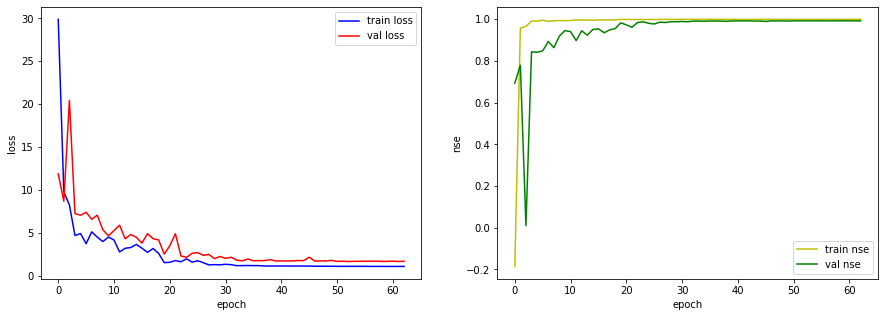

In [ ]:
fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['nse'], 'y', label='train nse')
loss_ax[1].plot(history.history['val_nse'], 'g', label='val nse')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('nse')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

## 결과 시각화

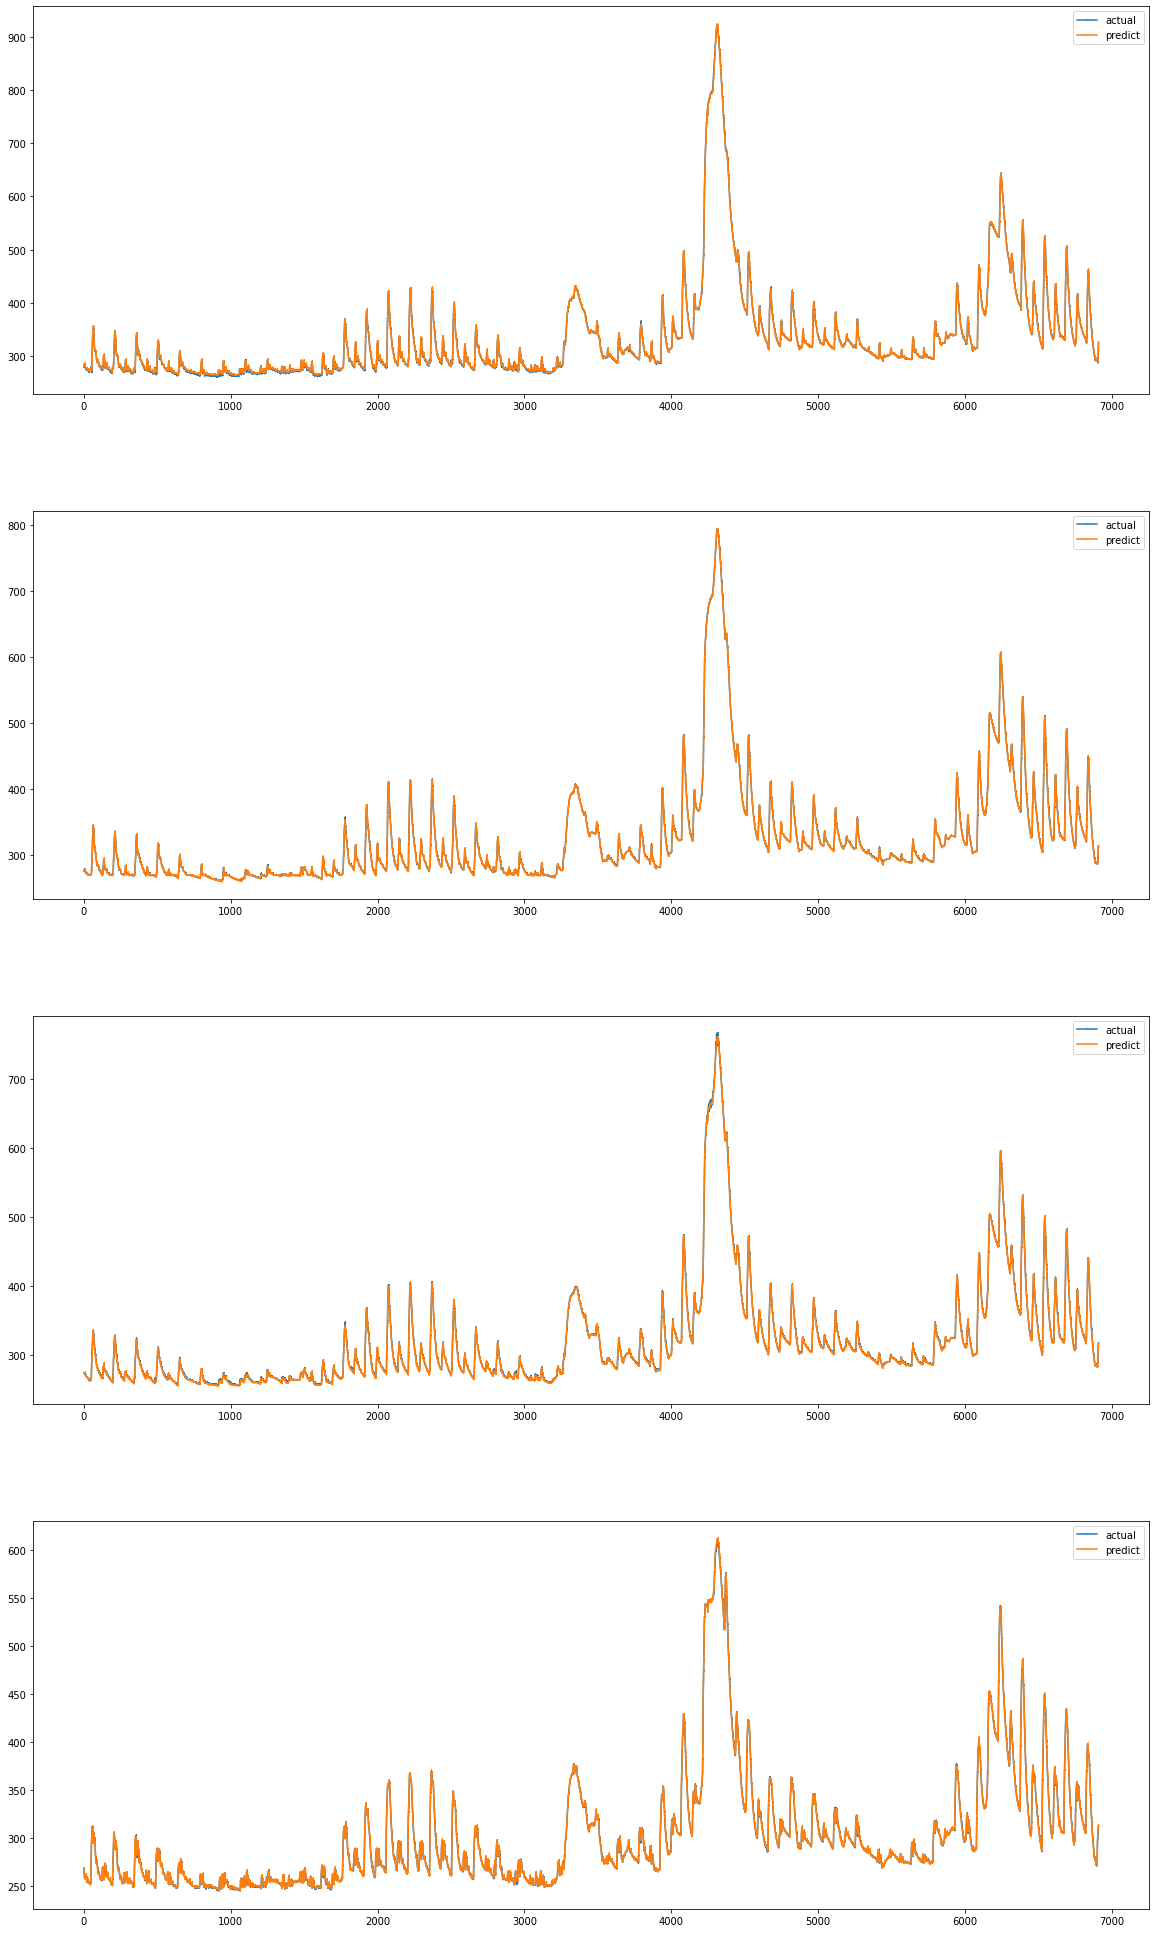

In [ ]:
tl_predict = np.array(yhat).T

#결과 시각화
f, axes = plt.subplots(4, 1)
f.set_size_inches((20, 35))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

for i in range(4):
    axes[i].plot(ytest_[i], marker = ",", label = "actual")
    axes[i].plot(tl_predict[i], marker = ",", label="predict")
    axes[i].legend(prop={'size':10})  

plt.show()

## 점수 확인

In [ ]:
score = []
for i in range(4):
    print(root_mean_squared_error(ytest_[i], tl_predict[i])  / r2_score(ytest_[i], tl_predict[i]))
    score.append(root_mean_squared_error(ytest_[i], tl_predict[i]) / r2_score(ytest_[i], tl_predict[i]))
    
print("최종점수: ", np.mean(score))

tf.Tensor(1.7150315388441073, shape=(), dtype=float64)
tf.Tensor(0.9307685564530979, shape=(), dtype=float64)
tf.Tensor(1.4111793330100453, shape=(), dtype=float64)
tf.Tensor(1.26410124341443, shape=(), dtype=float64)
최종점수:  1.33027016793042


## 파일 제출

In [ ]:
sample_submission = pd.read_csv("/content/drive/MyDrive/신입기수 프로젝트/DACON/competition_data/sample_submission.csv")

sample_submission["wl_1018662"] = tl_predict[0]
sample_submission["wl_1018680"] = tl_predict[1]
sample_submission["wl_1018683"] = tl_predict[2]
sample_submission["wl_1019630"] = tl_predict[3]

sample_submission.to_csv("/content/drive/MyDrive/신입기수 프로젝트/Dataset/0828_newdata7.csv", index = False)

## 결과 해석